## Importing stuff

In [1]:
import ipynb
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import lmfit
from pylcp.common import progressBar
import ast
import csv
import pickle
import scipy.constants as consts
from scipy.optimize import bisect
from tqdm import tqdm
from ipynb.fs.full.MagnetsInterpolation import ComsolMagCylindricalInterpolation as mi
import inspect

loadpath = "/csv/"
savepath = "/images/"

## Laser parameters and scaled units

In [73]:
#laser parameters
laser_det = -2
ham_det = 0
#laser power in Watts
laser_power = 0.1
#beam intensity 1/e^2 radius in cm
beamWidth = 0.3
#saturation intensity in W/cm^2
Isat = 1
s = laser_power/(Isat*np.pi*beamWidth**2)

#scaled mass as described in the examples, for 114 Cd
scaledMass = 4.87e-3

# Hamiltonian for F=0->F=1, with zero Zeeman shift in the ground state
Hg, Bgq = pylcp.hamiltonians.singleF(F=0, gF=0, muB=1)
He, Beq = pylcp.hamiltonians.singleF(F=1, gF=1, muB=1)
dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)
ham_toy = pylcp.hamiltonian(Hg, He - ham_det*np.eye(3), Bgq, Beq, dijq,mass=scaledMass)

#Hamiltonian for F=1/2 -> F = 1/2,3/2 
HgFermion, BgqFermion = pylcp.hamiltonians.hyperfine_coupled(J=0, I=1/2, gJ=0, gI=0, Ahfs=0, Bhfs=0, Chfs=0, muB=1)
HeFermion, BeqFermion = pylcp.hamiltonians.hyperfine_coupled(J=1, I=1/2, gJ=1, gI=0, Ahfs=2.2, Bhfs=0, Chfs=0, muB=1)
dijqFermion = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(J=0, Jp=1, I=0.5)
ham_fermions = pylcp.hamiltonian(HgFermion, HeFermion - ham_det*np.eye(6), BgqFermion, BeqFermion, dijqFermion,mass=scaledMass)

In [74]:
s

0.35367765131532297

## Laser configurations

In [ ]:
class LaserConfig:
    def __init__(self, config):
        self.config = config
        if config = 
        
    def 

In [6]:
#magnetic field gradient expressed as a Zeeman shift (units of Gamma) per cm
alpha =8
magField = pylcp.quadrupoleMagneticField(alpha)
#magField = pylcp.constantMagneticField(np.zeros(3))
laserBeams = {}

#Here I define a set of laser beams in MOT configuration, where the laser beams are defined so that the beam line for the atoms is along the x-axis. 
#This means the radial trapping beams are at 45 degrees to the coordinate system. Useful when considering how the MOT loads from a buffer gas beam.
laserBeams['MOT45'] = pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

#Here I define a set of laser beams each propagating along the cartesian axes (simple to think about)
laserBeams['MOT'] = pylcp.laserBeams([
    {'kvec':np.array([-1.0, 0., 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([1.0, 0.,0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([0.0, -1.0, 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([0.0, 1.0, 0.]), 'pol':-1, 'delta':laser_det, 's':s},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s}
    ], beam_type=pylcp.infinitePlaneWaveBeam)

#The same thing with gaussian beams
laserBeams['MOT45gaussian'] = pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth}
    ], beam_type=pylcp.gaussianBeam)

laserBeams['MOTgaussian'] = pylcp.laserBeams([
    {'kvec':np.array([-1.0, 0., 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1.0, 0.,0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0.0, -1.0, 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0.0, 1.0, 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth}
    ], beam_type=pylcp.gaussianBeam)

#Here I add another laser beam configuration for the Cd MOT, which includes a slowing beam along the x axis

laser_det_slower = -10
beamWidth_slower = 0.3
s_slower = 0.2
laserBeams['CdMOTZeemanSlower'] = pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1, 0., 0.]), 'pol':+1, 'delta':laser_det_slower, 's':s_slower,'wb':beamWidth_slower}
    ], beam_type=pylcp.gaussianBeam)

laserBeams['CdMOTZeemanSlowerSigmaPlus'] = pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1, 0., 0.]), 'pol':-1, 'delta':laser_det_slower, 's':s_slower,'wb':beamWidth_slower}
    ], beam_type=pylcp.gaussianBeam)

laserBeams['CdMOTZeemanSlowerLinear'] = pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1, 0., 0.]), 'pol':np.array([1,0,1]), 'delta':laser_det_slower, 's':s_slower,'wb':beamWidth_slower}
    ], beam_type=pylcp.gaussianBeam)

#Just the Zeeman slower
laserBeams['CdZeemanSlower'] = pylcp.laserBeams([
    {'kvec':np.array([-1, 0., 0.]), 'pol':-1, 'delta':laser_det_slower, 's':s_slower,'wb':beamWidth_slower}
    ], beam_type=pylcp.gaussianBeam)

laserBeams['CdMOTZeemanSlowerSigmaPlus_F1/2'] = pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det-2, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det-2, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det-2, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det-2, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det-2, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det-2, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1, 0., 0.]), 'pol':-1, 'delta':laser_det_slower, 's':s_slower,'wb':beamWidth_slower}
    ], beam_type=pylcp.gaussianBeam)




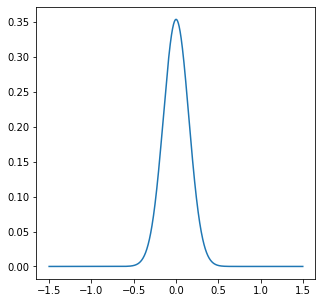

In [7]:
#Here I just check that the gaussian beam intensity profile actually works
fig, ax = plt.subplots(1, 1, num='MOTgaussian', figsize=(5, 5))
x=np.arange(-5,5,0.01)*beamWidth
ax.plot(x, [laserBeams['MOTgaussian'].intensity(np.array([0,ii,0.]),t=0)[5] for ii in x])

## Simple force curve comparison

In [8]:
#make Rate equation force curves for both sets of beams
rateeq={}

# Define a v axis:
vz = np.arange(-5.0, 5.1, 0.125)
vy = np.arange(-5.0, 5.1, 0.125)
vx = np.arange(-5.0, 5.1, 0.125)
z = np.arange(-1.0, 1.01, 0.025)*5*beamWidth
y = np.arange(-1.0, 1.01, 0.025)*5*beamWidth
x = np.arange(-1.0, 1.01, 0.025)*5*beamWidth
for jj, key in enumerate(laserBeams.keys()):
    print('Working on %s:' % key)
    rateeq[key] = pylcp.rateeq(laserBeams[key], magField, ham_toy,include_mag_forces=False)
    
    # Generate forces: F(v) at the trap centre
    rateeq[key].generate_force_profile(
        [0.*np.ones(vx.shape), 0.*np.ones(vx.shape), np.zeros(vx.shape)],
        [vx,np.zeros(vx.shape), np.zeros(vx.shape)],
        name='vx', progress_bar = True
    )

    rateeq[key].generate_force_profile(
        [0.*np.ones(vy.shape), 0.*np.ones(vy.shape), np.zeros(vy.shape)],
        [np.zeros(vy.shape),vy, np.zeros(vy.shape)],
        name='vy', progress_bar = True
    )
    
    rateeq[key].generate_force_profile(
        [0.*np.ones(vz.shape), 0.*np.ones(vz.shape), np.zeros(vz.shape)],
        [np.zeros(vz.shape), np.zeros(vz.shape),vz],
        name='vz', progress_bar = True
    )
      
        # Generate forces: F(r) at v = 0:
    rateeq[key].generate_force_profile(
        [x,np.zeros(x.shape), np.zeros(x.shape)],
        [np.zeros(x.shape), np.zeros(x.shape), np.zeros(x.shape)],
        name='x', progress_bar = True
    )
    
    rateeq[key].generate_force_profile(
        [np.zeros(y.shape),y, np.zeros(y.shape)],
        [np.zeros(y.shape), np.zeros(y.shape), np.zeros(y.shape)],
        name='y', progress_bar = True
    )
    
    rateeq[key].generate_force_profile(
        [np.zeros(z.shape),np.zeros(z.shape),z],
        [np.zeros(z.shape), np.zeros(z.shape), np.zeros(z.shape)],
        name='z', progress_bar = True
    )

  

Working on MOT45:
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.05 s.                                              
Working on MOT:
Completed in 0.03 s.                                              
Completed in 0.03 s.                                              
Completed in 0.03 s.                                              
Completed in 0.03 s.                                              
Completed in 0.03 s.                                              
Completed in 0.04 s.                                              
Working on MOT45gaussian:
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Co

No handles with labels found to put in legend.


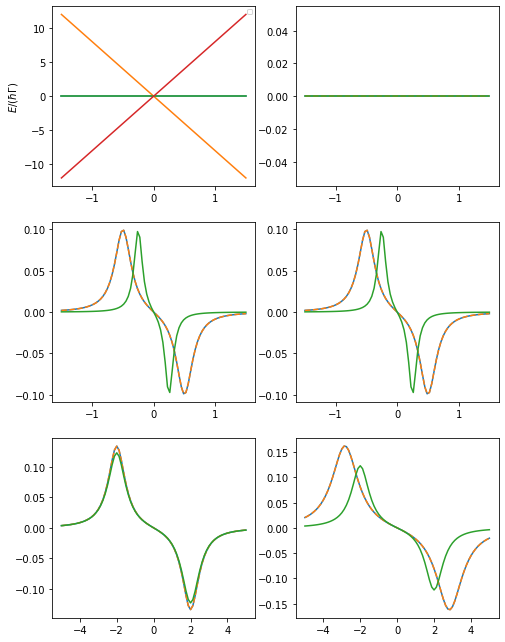

In [9]:
#Since we used gaussian beams, the radial force drops off faster along the x-axis for the MOT45 configuration, because the trapping beam intensity falls off in this direction. 
fig, ax = plt.subplots(3, 2, num='MOT J=1-1', figsize=(8, 5*2.25))

Es = np.zeros((z.size, 4))
for ii, z_i in enumerate(z):
    Bq = np.array([0., magField.Field(np.array([0., 0., z_i]))[2],0])
    Es[ii, :] = np.real(np.diag(ham_toy.return_full_H({'g->e':np.array([0., 0., 0.])}, Bq)))

[ax[0, 0].plot(z, Es[:, 0+jj]) for jj in range(4)]
ax[0, 0].legend(fontsize=6)
ax[0, 0].set_ylabel('$E/(\hbar \Gamma)$')

ax[2,0].plot(vx,rateeq['MOT'].profile['vx'].F[0])
ax[2,0].plot(vy,rateeq['MOT'].profile['vy'].F[1], '--')
ax[2,0].plot(vz,rateeq['MOT'].profile['vz'].F[2])


ax[1,0].plot(x,rateeq['MOT'].profile['x'].F[0])
ax[1,0].plot(y,rateeq['MOT'].profile['y'].F[1],'--')
ax[1,0].plot(z,rateeq['MOT'].profile['z'].F[2])

ax[0,1].plot(x,rateeq['MOT'].profile['x'].f_mag[0])
ax[0,1].plot(y,rateeq['MOT'].profile['y'].f_mag[1],'--')
ax[0,1].plot(z,rateeq['MOT'].profile['z'].f_mag[2])

ax[2,1].plot(vx,rateeq['MOT45'].profile['vx'].F[0])
ax[2,1].plot(vy,rateeq['MOT45'].profile['vy'].F[1], '--')
ax[2,1].plot(vz,rateeq['MOT45'].profile['vz'].F[2],)


ax[1,1].plot(x,rateeq['MOT45'].profile['x'].F[0])
ax[1,1].plot(y,rateeq['MOT45'].profile['y'].F[1],'--')
ax[1,1].plot(z,rateeq['MOT45'].profile['z'].F[2])



## 2D Force plots 

In [10]:
#now let's plot the phase space force plot for the MOT configuration - should look pretty similar to the one on the examples page
dr = 0.05
dv = 0.05
r = beamWidth*np.arange(-10, 10+dr, dr)
v = np.arange(-10, 10+dv, dv)

R, V = np.meshgrid(r, v)

#Rfull = np.array([sqrt(2)*R, sqrt(2)*R, np.zeros(R.shape)])
#Vfull = np.array([sqrt(2)*V, sqrt(2)*V, np.zeros(V.shape)])

rateeq['MOTgaussian'].generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

Completed in 1:19.                                                  


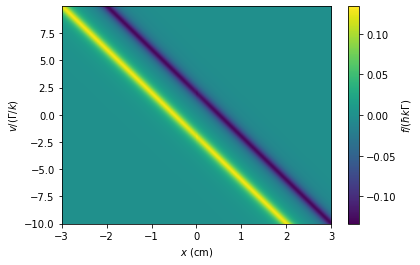

In [11]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq['MOTgaussian'].profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

In [90]:
#Do the same for the MOT45 configuration - should see the effect of gaussian beams
dr = 0.05
dv = 0.05
r = beamWidth*np.arange(-35, 20+dr, 2*dr)
v = np.arange(-10, 17+dv, 2*dv)

R, V = np.meshgrid(r, v)

#Rfull = np.array([sqrt(2)*R, sqrt(2)*R, np.zeros(R.shape)])
#Vfull = np.array([sqrt(2)*V, sqrt(2)*V, np.zeros(V.shape)])

rateeq['MOT45gaussian'].generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

Completed in 1:19.                                                  


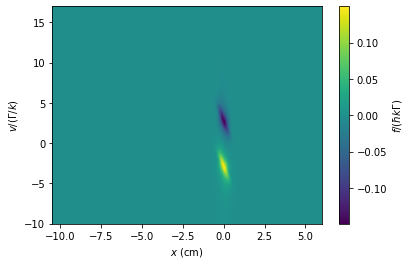

In [91]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq['MOT45gaussian'].profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

## Capture Velocity

In [101]:
#sightly adjusted from the examples page
v0s =np.arange(1.5, 12, 1)

# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-1):
    if (abs(y[0])<threshold and abs(y[-3])<1e-1):
        val = 1.
    else:
        val = -1.

    return val

def lost_condition(t, y, threshold=1e-2):
    if y[-3]>10:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

sols = []
for v0 in v0s:
    rateeq['MOT45gaussian'].set_initial_position_and_velocity(np.array([-10, 0., 0.]),
                                          np.array([v0, 0., 0.]))
    if isinstance(rateeq['MOT45gaussian'], pylcp.rateeq):
        rateeq['MOT45gaussian'].set_initial_pop(np.array([1., 0., 0., 0.]))

    rateeq['MOT45gaussian'].evolve_motion([0., 10.], events=[captured_condition, lost_condition], max_step=1, progress_bar=True)

    sols.append(rateeq['MOT45gaussian'].sol)

Completed in 1.55 s.                                               
Completed in 6.98 s.                                               
Completed in 3.75 s.                                               s
Completed in 8.84 s.                                               
Completed in 0.02 s.                                              
Completed in 0.02 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Completed in 0.02 s.                                              
Completed in 0.01 s.                                              


In [102]:
for sol in sols:
    if (abs(sol.r[0][-1])<1e-3 and abs(sol.v[0][-1])<1e-2):
        print('initial velocity: '+ str(sol.v[0][0]) +' captured')
    elif len(sol.t_events[1]) == 1:
        print('initial velocity: '+ str(sol.v[0][0]) +' lost')

initial velocity: 1.5 captured
initial velocity: 2.5 captured
initial velocity: 3.5 captured
initial velocity: 4.5 captured
initial velocity: 5.5 lost
initial velocity: 6.5 lost
initial velocity: 7.5 lost
initial velocity: 8.5 lost
initial velocity: 9.5 lost
initial velocity: 10.5 lost
initial velocity: 11.5 lost


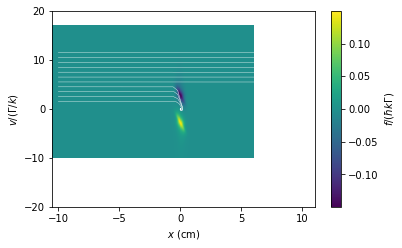

In [103]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq['MOT45gaussian'].profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v/(\Gamma/k)$')

fig.subplots_adjust(left=0.15, right=0.91, bottom=0.2)

for sol in sols:
    ax.plot(sol.r[0], sol.v[0], 'w-', linewidth=0.375)

ax.yaxis.set_ticks([-20, -10, 0, 10, 20])
# Display the figure at the end of the thing.

(-10.0, 6.0)

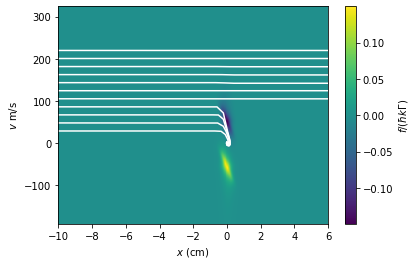

In [109]:
v_calibration = 19.1

fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq['MOT45gaussian'].profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   v_calibration*(np.amin(v)-dv/2), v_calibration*(np.amax(v)-dv/2)),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v$ m/s')
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols:
    ax.plot(sol.r[0], v_calibration*sol.v[0], 'w-')
ax.set_xlim(-10,6)


In [110]:
fig.savefig(savepath+'NoSlower.pdf')

In [217]:
#A function which finds the capture velocity. Give it arrays of length 3 for initial coordinates

def isCaptured(sol):
    captured = -1
    finalPosition = np.array([sol.r[i][-1] for i in range(3)])
    finalVelocity = np.array([sol.v[i][-1] for i in range(3)]) 
    if (np.linalg.norm(finalPosition) <1e-2 and np.linalg.norm(finalVelocity) <1e-2):
        #print('initial velocity: '+ str(sol.v[0][0]) +' captured')
        captured = 1 
    return captured
    
def atomTrajectoryToMOT(v0, r0, eqn, captured_condition, lost_condition, tmax=100, max_step=0.1, **kwargs):
    eqn.set_initial_position_and_velocity(r0, np.array([v0,0,0]))
    eqn.evolve_motion([0., tmax], #events=[captured_condition, lost_condition],
                      max_step=max_step)
    return isCaptured(eqn.sol)

def findCaptureVelocity(r0,eqn):
    if(atomTrajectoryToMOT(0.5, r0, eqn, captured_condition, lost_condition, tmax=100, max_step=0.1)==-1):
        return 0
    else:
        return bisect(atomTrajectoryToMOT, 0.5, 15.,
       args=(r0, eqn, captured_condition, lost_condition),
       xtol=1e-4, rtol=1e-4, full_output=False)
    
    


In [79]:
#Plot the capture velocity as a function of transverse displacement
capVel_yDisplacement = [findCaptureVelocity(np.array([-10,y,0]), rateeq['MOT45gaussian']) for y in tqdm(np.arange(-0.5,0.5,0.05))]
capVel_zDisplacement = [findCaptureVelocity(np.array([-10,0,z]), rateeq['MOT45gaussian']) for z in tqdm(np.arange(-0.5,0.5,0.05))]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:58<00:00, 44.94s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [15:06<00:00, 45.31s/it]


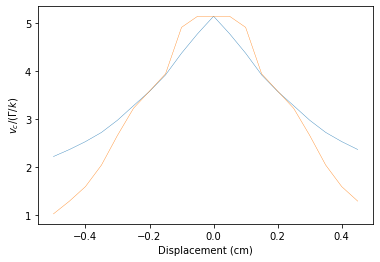

In [85]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(-0.5,0.5,0.05), capVel_yDisplacement, '-', linewidth=0.375)
ax.plot(np.arange(-0.5,0.5,0.05), capVel_zDisplacement, '-', linewidth=0.375)
ax.set_xlabel('Displacement (cm)')
ax.set_ylabel('$v_c/(\Gamma/k)$');

In [62]:
yDisplacement, zDisplacement = np.arange(-0.5,0.5,0.05),np.arange(-0.5,0.5,0.05)

In [63]:
Ys, Zs = np.meshgrid(yDisplacement, zDisplacement)

it = np.nditer([Ys, Zs, None, None],
               op_dtypes=['float64', 'float64', 'float64', np.object])

progress = progressBar()
for (yDisplacement, zDisplacement, vc, full_results) in it:
    
    vc[...] = findCaptureVelocity(np.array([-5,yDisplacement,zDisplacement]), rateeq['MOT45gaussian'])

    progress.update((it.iterindex+1)/it.itersize)

<ipython-input-63-f41dad0123b0>:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  op_dtypes=['float64', 'float64', 'float64', np.object])


Completed in 5:35:28.                                               


In [45]:
 findCaptureVelocity(np.array([-10,1,1]), rateeq['MOT45gaussian'])

0

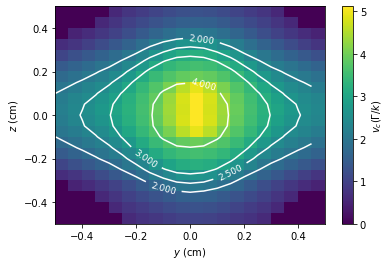

In [83]:
fig, ax = plt.subplots(1, 1)
plt.imshow(it.operands[2], origin='lower',
           extent=(-0.5, 0.5,
                   -0.5, 0.5),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$v_c (\Gamma/k)$')
ax.set_xlabel('$y$ (cm)')
ax.set_ylabel('$z$ (cm)')
CS=ax.contour(Ys,Zs,it.operands[2],np.array([2,2.5,3,4]),colors = 'w')
ax.clabel(CS, fontsize=9, inline=True)
fig.subplots_adjust(left=0.12,right=0.9)

## Permanent magnets

In [98]:
permMagnets=mi('2D_Br.csv', '2D_Bz.csv',91,-1)

In [99]:
permMagnetsPylcp = pylcp.magField(permMagnets.fieldCartesian)

C:\Users\Wright\Nextcloud\CdMOT calculation work\Pylcp\MagnetsInterpolation.ipynb:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "        #For pylcp to use it, it is better to keep the function arguments as R, t \"(promote_to_lambda seems to like finding the function signatures this way to test it)\"\n",
C:\Users\Wright\Nextcloud\CdMOT calculation work\Pylcp\MagnetsInterpolation.ipynb:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "        #For pylcp to use it, it is better to keep the function arguments as R, t \"(promote_to_lambda seems to li

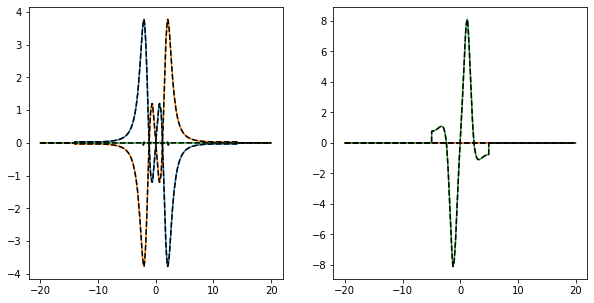

In [100]:
#Now if I make the radial and axial plots, they should still look as expected. Along the line y=-x, By =-Bx by symmetry.
posns = np.arange(-20.0,20.0,0.02)
fig, ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(posns,np.array([permMagnets.fieldCartesian(np.array([-i/np.sqrt(2),i/np.sqrt(2),0]),0) for i in posns]))
ax[1].plot(posns,np.array([permMagnets.fieldCartesian(np.array([0.0,0.0,i]),0) for i in posns]))

#checking that the pylcp still gets the same field profiles
ax[0].plot(posns,np.array([permMagnetsPylcp.Field(np.array([-i/np.sqrt(2),i/np.sqrt(2),0]),0) for i in posns]), 'k--')
ax[1].plot(posns,np.array([permMagnetsPylcp.Field(np.array([0.0,0.0,i]),0) for i in posns]), 'k--')

C:\Users\Wright\Nextcloud\CdMOT calculation work\Pylcp\MagnetsInterpolation.ipynb:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  "        #For pylcp to use it, it is better to keep the function arguments as R, t \"(promote_to_lambda seems to like finding the function signatures this way to test it)\"\n",


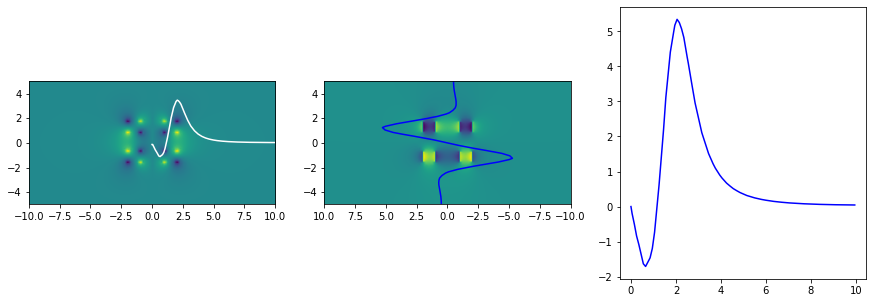

In [101]:
#making a color plot of the radial and axial field components and overlaying the on axis field profiles:  
r = np.arange(0,10,0.05)
z = np.arange(-5,5,0.05)

fig, ax = plt.subplots(1,3,figsize=[15,5])
ax[0].imshow(np.transpose(permMagnets.bRad(r, z)),extent=(0,-10,-5,5), origin='lower')
ax[0].imshow(np.transpose(permMagnets.bRad(r, z)),extent=(0,10,-5,5), origin='lower')
ax[0].plot(r,10**(-2)*permMagnets.bRad(r,0),'w-')

ax[1].imshow(np.transpose(permMagnets.bAx(r, z)),extent=(0,10,-5,5), origin='lower')
ax[1].imshow(np.transpose(permMagnets.bAx(r, z)),extent=(0,-10,-5,5), origin='lower')
ax[1].plot(np.ndarray.flatten(10**(-2)*permMagnets.bAx(0,z)),z,'b-')

ax[2].plot(r,np.ndarray.flatten(np.array([permMagnetsPylcp.Field(np.array([i,0,0]),0)[0] for i in r])),'b-')

Text(0, 0.5, '$B_{r}$')

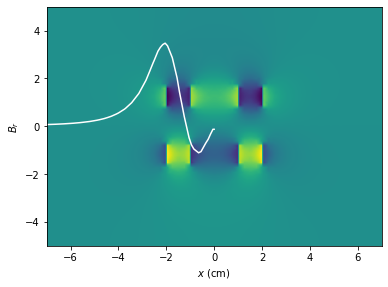

In [102]:
r = np.arange(0,10,0.05)
z = np.arange(-5,5,0.05)

fig, ax = plt.subplots(1,1,figsize=[6,5])
ax.imshow(np.transpose(permMagnets.bAx(r, z)),extent=(0,-10,-5,5), origin='lower')
ax.imshow(np.transpose(permMagnets.bAx(r, z)),extent=(0,10,-5,5), origin='lower')
ax.plot(-r,10**(-2)*permMagnets.bRad(r,0),'w-')
ax.set_xlim(-7,7)
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$B_{r}$')


In [11]:
fig.savefig(savepath+'Magnets_plot.pdf')

In [80]:
#make Rate equation force curves for both sets of beams
rateeq={}

# Define a v axis:
vz = np.arange(-5.01, 5.1, 0.125)
vy = np.arange(-5.01, 5.1, 0.125)
vx = np.arange(-5.01, 5.1, 0.125)
z = np.arange(-1.01, 1.01, 0.025)*5*beamWidth
y = np.arange(-1.01, 1.01, 0.025)*5*beamWidth
x = np.arange(-1.01, 1.01, 0.025)*5*beamWidth
for jj, key in enumerate(laserBeams.keys()):
    print('Working on %s:' % key)
    rateeq[key] = pylcp.rateeq(laserBeams[key], permMagnetsPylcp, ham_toy,include_mag_forces=False)
    
    # Generate forces: F(v) at the trap centre
    rateeq[key].generate_force_profile(
        [0.001*np.ones(vx.shape), 0.001*np.ones(vx.shape), np.zeros(vx.shape)],
        [vx,np.zeros(vx.shape), np.zeros(vx.shape)],
        name='vx', progress_bar = True
    )

        # Generate forces: F(r) at v = 0:
    rateeq[key].generate_force_profile(
        [x,np.zeros(x.shape), np.zeros(x.shape)],
        [np.zeros(x.shape), np.zeros(x.shape), np.zeros(x.shape)],
        name='x', progress_bar = True
    )


Working on MOT45:
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Working on MOT:
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Working on MOT45gaussian:
Completed in 0.05 s.                                              
Completed in 0.04 s.                                              
Working on MOTgaussian:
Completed in 0.04 s.                                              
Completed in 0.04 s.                                              
Working on CdMOTZeemanSlower:
Completed in 0.05 s.                                              
Completed in 0.05 s.                                              
Working on CdMOTZeemanSlowerSigmaPlus:
Completed in 0.05 s.                                              
Completed in 0.05 s.                                              
Working on CdMOTZeemanSlowerLinear:
Complet

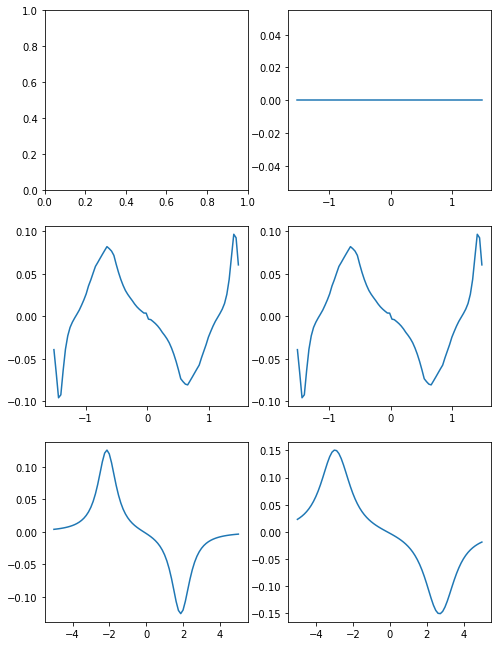

In [81]:
#Since we used gaussian beams, the radial force drops off faster along the x-axis for the MOT45 configuration, because the trapping beam intensity falls off in this direction. 
fig, ax = plt.subplots(3, 2, num='MOT J=1-1', figsize=(8, 5*2.25))

ax[2,0].plot(vx,rateeq['MOT'].profile['vx'].F[0])
#ax[2,0].plot(vy,rateeq['MOT'].profile['vy'].F[1], '--')
#ax[2,0].plot(vz,rateeq['MOT'].profile['vz'].F[2])


ax[1,0].plot(x,rateeq['MOT'].profile['x'].F[0])
#ax[1,0].plot(y,rateeq['MOT'].profile['y'].F[1],'--')
#ax[1,0].plot(z,rateeq['MOT'].profile['z'].F[2])

ax[0,1].plot(x,rateeq['MOT'].profile['x'].f_mag[0])
#ax[0,1].plot(y,rateeq['MOT'].profile['y'].f_mag[1],'--')
#ax[0,1].plot(z,rateeq['MOT'].profile['z'].f_mag[2])

ax[2,1].plot(vx,rateeq['MOT45'].profile['vx'].F[0])
#ax[2,1].plot(vy,rateeq['MOT45'].profile['vy'].F[1], '--')
#ax[2,1].plot(vz,rateeq['MOT45'].profile['vz'].F[2],)


ax[1,1].plot(x,rateeq['MOT45'].profile['x'].F[0])
#ax[1,1].plot(y,rateeq['MOT45'].profile['y'].F[1],'--')
#ax[1,1].plot(z,rateeq['MOT45'].profile['z'].F[2])


In [82]:
#Do the same for the MOT45 configuration - should see the effect of gaussian beams
dr = 0.05
dv = 0.05
r = beamWidth*np.arange(-10, 10+dr, dr)
v = np.arange(-10, 10+dv, dv)

R, V = np.meshgrid(r, v)

#Rfull = np.array([sqrt(2)*R, sqrt(2)*R, np.zeros(R.shape)])
#Vfull = np.array([sqrt(2)*V, sqrt(2)*V, np.zeros(V.shape)])

rateeq['MOT45gaussian'].generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

rateeq['MOT45'].generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

Completed in 1:27.                                                  
Completed in 1:17.                                                  


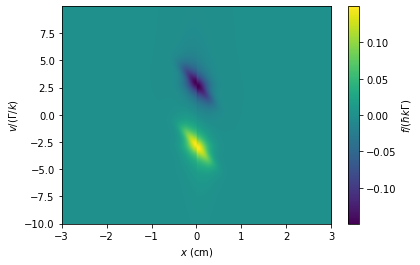

In [16]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq['MOT45gaussian'].profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

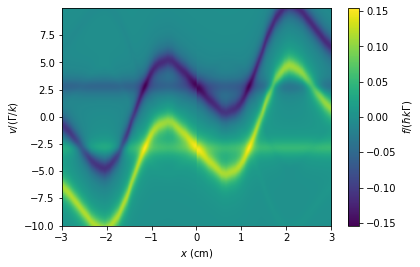

In [19]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq['MOT45'].profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

In [17]:
magField.Field([0.1,0.1,0.1])

array([-0.4, -0.4,  0.8])

In [18]:
permMagnets.fieldCartesian([0.1,0.1,0.1],0)

array([-0.34190891, -0.34190891,  0.69241114])

## Simulating capture into the MOT from the Zeeman slower

In [105]:
v0s =np.arange(1.5, 12, 1)

def captured_condition(t, y, threshold=1e-1):
    if (abs(y[0])<threshold and abs(y[-3])<1e-1):
        val = 1.
    else:
        val = -1.

    return val

def lost_condition(t, y, threshold=1e-2):
    if y[-3]>10:
        val = -1.
    else:
        val = 1.

    return val

slowerRE = pylcp.rateeq(laserBeams['CdMOTZeemanSlowerSigmaPlus'], permMagnetsPylcp, ham_toy,include_mag_forces=False)
slowerRE.set_initial_position_and_velocity(np.array([-10, 0., 0.]),
                                          np.array([3.5, 0., 0.]))
slowerRE.set_initial_pop(np.array([1., 0., 0., 0.]))

captured_condition.terminal=True
lost_condition.terminal=True

sol = slowerRE.evolve_motion([0., 10.], max_step=0.05, events=[captured_condition, lost_condition], progress_bar=True)

slowerRESigmaMinus = pylcp.rateeq(laserBeams['CdMOTZeemanSlower'], permMagnetsPylcp, ham_toy,include_mag_forces=False)
slowerRESigmaMinus.set_initial_position_and_velocity(np.array([-10, 0., 0.]),
                                          np.array([11.5, 0., 0.]))
slowerRESigmaMinus.set_initial_pop(np.array([1., 0., 0., 0.]))
sol2 = slowerRESigmaMinus.evolve_motion([0., 10.], max_step=0.05, events=[captured_condition, lost_condition], progress_bar=True)

sols = []
for v0 in v0s:
    rateeq['CdMOTZeemanSlowerSigmaPlus'].set_initial_position_and_velocity(np.array([-10, 0., 0.]),
                                          np.array([v0, 0., 0.]))
    if isinstance(rateeq['CdMOTZeemanSlowerSigmaPlus'], pylcp.rateeq):
        rateeq['CdMOTZeemanSlowerSigmaPlus'].set_initial_pop(np.array([1., 0., 0., 0.]))

    rateeq['CdMOTZeemanSlowerSigmaPlus'].evolve_motion([0., 10.], events=[captured_condition, lost_condition], max_step=0.1, progress_bar=True)

    sols.append(rateeq['CdMOTZeemanSlowerSigmaPlus'].sol)

Completed in 9.77 s.                                               
Completed in 0.19 s.                                              
Completed in 0.34 s.                                              
Completed in 6.63 s.                                               
Completed in 9.33 s.                                               
Completed in 13.69 s.                                              
Completed in 24.52 s.                                              
Completed in 12.23 s.                                              s
Completed in 17.10 s.                                              
Completed in 20.92 s.                                              
Completed in 17.00 s.                                              
Completed in 19.72 s.                                              s
Completed in 18.92 s.                                              


[[<matplotlib.lines.Line2D at 0x1ba69575670>],

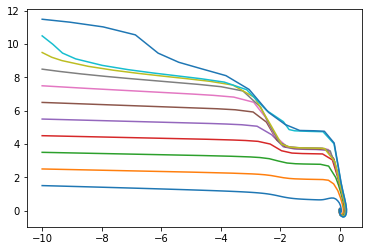

In [107]:
fig, ax = plt.subplots(1, 1)
[ax.plot(i.r[0],i.v[0]) for i in sols]

In [67]:
#Do the same for the MOT45 configuration - should see the effect of gaussian beams
dr = 0.1
dv = 0.1
r = beamWidth*np.arange(-35, 20+dr, 2*dr)
v = np.arange(-10, 17+dv, 2*dv)

R, V = np.meshgrid(r, v)

#Rfull = np.array([sqrt(2)*R, sqrt(2)*R, np.zeros(R.shape)])
#Vfull = np.array([sqrt(2)*V, sqrt(2)*V, np.zeros(V.shape)])

slowerRE.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

Completed in 21.21 s.                                               


(-10.0, 6.0)

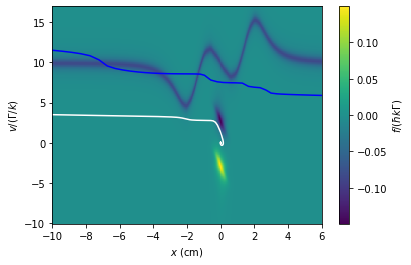

In [68]:
fig, ax = plt.subplots(1, 1)
plt.imshow(slowerRE.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

ax.plot(sol.r[0],sol.v[0],'w-')
ax.plot(sol2.r[0],sol2.v[0],'b-')
ax.set_xlim(-10,6)

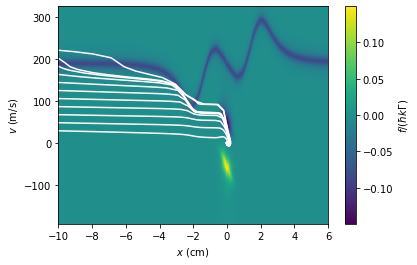

In [88]:
#the same plot but with the velocity axis in m/s
v_calibration = 19.15

fig, ax = plt.subplots(1, 1)
plt.imshow(slowerRE.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   v_calibration*(np.amin(v)-dv/2), v_calibration*(np.amax(v)-dv/2)),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$x$ (cm)')
ax.set_ylabel('$v$ (m/s)')
fig.subplots_adjust(left=0.12,right=0.9)

[ax.plot(i.r[0],v_calibration*i.v[0], 'w-') for i in sols]
#ax.plot(sol2.r[0],v_calibration*sol2.v[0],'b-')
ax.set_xlim(-10,6)
plt.show()

In [89]:
fig.savefig(savepath+'ZeemanSlowerTrajectories.png')

# Scanning the polarisation of the Zeeman slower light

In [524]:
def MOTslowerBeams(s_slower,pol_slower,det_slower):
    return pylcp.laserBeams([
    {'kvec':np.array([-1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([1/np.sqrt(2), -1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1/np.sqrt(2), 1/np.sqrt(2), 0.]), 'pol':-1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0.,  1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([0., 0., -1.]), 'pol':+1, 'delta':laser_det, 's':s,'wb':beamWidth},
    {'kvec':np.array([-1, 0., 0.]), 'pol':np.array([0,np.exp(1j*pol_slower),np.exp(-1j*pol_slower)]),'pol_coord':'cartesian', 'delta':det_slower, 's':s_slower,'wb':beamWidth_slower}
    ], beam_type=pylcp.gaussianBeam)

def captured_condition(t, y):
    return (y[-6]**2 + y[-3]**2) - 1e-2

def lost_condition(t, y):
    return y[-3]-2

   
def captureVelocityForEq(s_slower,pol_slower,det_slower):
    eq = pylcp.rateeq(MOTslowerBeams(s_slower,pol_slower,det_slower),permMagnetsPylcp, ham_toy,include_mag_forces=False)
       
    eq.set_initial_pop(np.array([1., 0., 0., 0.]))
    
    return findCaptureVelocity(np.array([-10,0,0]), eq)
    

def isCaptured(sol):
    captured = -1
    finalPosition = np.array([sol.r[i][-1] for i in range(3)])
    finalVelocity = np.array([sol.v[i][-1] for i in range(3)]) 
    if (np.linalg.norm(finalPosition)**2 + np.linalg.norm(finalVelocity)**2 <1.1e-2):
        #print('initial velocity: '+ str(sol.v[0][0]) +' captured')
        captured = 1 
    return captured

def atomTrajectoryToMOT(v0, r0, eqn, tmax=10, max_step=1, **kwargs):
    eqn.set_initial_position_and_velocity(r0, np.array([v0,0,0]))
    eqn.evolve_motion([0., 10], events=[captured_condition,lost_condition],
                      max_step=max_step)

    return isCaptured(eqn.sol)

def findCaptureVelocity(r0,eqn):
    if(atomTrajectoryToMOT(2, r0, eqn, tmax=10, max_step=1)==-1):
        return 0
    else:
        return bisect(atomTrajectoryToMOT,2, 15.,
       args=(r0, eqn),
       xtol=1e-3, rtol=1e-3, full_output=False)

In [525]:
eq = pylcp.rateeq(MOTslowerBeams(0.35,+np.pi/4,-10),permMagnetsPylcp, ham_toy,include_mag_forces=False)
eq.set_initial_pop(np.array([1., 0., 0., 0.]))
eq.set_initial_position_and_velocity(np.array([-10, 0., 0.]),
                                          np.array([15, 0., 0.]))

captured_condition.terminal=True
lost_condition.terminal=True

sol = eq.evolve_motion([0., 10], 
                      max_step=1, events = [captured_condition,lost_condition])

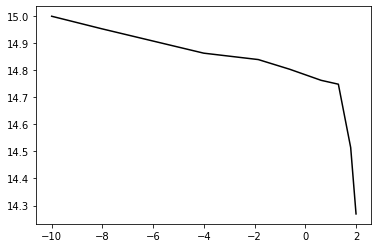

In [526]:
fig, ax = plt.subplots(1, 1)
ax.plot(sol.r[0],sol.v[0], 'k-')

In [527]:
capVsPol = [[captureVelocityForEq(s,i,-10) for i in np.arange(-np.pi/4, 3*np.pi/4, 0.1)] for s in [0.1,0.2,0.3,0.35]]

Text(0, 0.5, 'Capture velocity (m/s)')

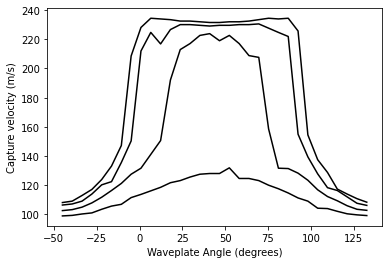

In [529]:
velocityCalibration = 19.15
fig, ax = plt.subplots(1, 1)
[ax.plot(45*4/np.pi*np.arange(-np.pi/4, 3*np.pi/4, 0.1),np.array([velocityCalibration])*i, 'k-') for i in capVsPol]
ax.set_xlabel('Waveplate Angle (degrees)')
ax.set_ylabel('Capture velocity (m/s)')

In [531]:
fig.savefig(savepath+'CapVel_ZS_polScan_sScan_det--10.pdf')

In [538]:
capVsS = [captureVelocityForEq(s,np.pi/4,-10) for s in np.arange(0.0,0.35,0.01)]

In [541]:
capVsSOtherCP = [captureVelocityForEq(s,-np.pi/4,-10) for s in np.arange(0.0,0.35,0.01)]

Text(0, 0.5, 'Capture velocity (m/s)')

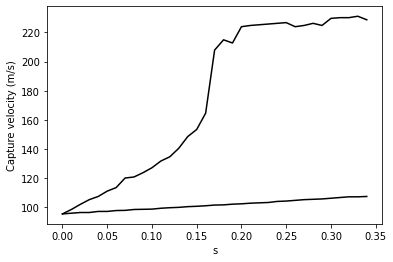

In [542]:
velocityCalibration = 19.15
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(0.0,0.35,0.01),np.array([velocityCalibration])*capVsS, 'k-') 
ax.plot(np.arange(0.0,0.35,0.01),np.array([velocityCalibration])*capVsSOtherCP, 'k-') 
ax.set_xlabel('s')
ax.set_ylabel('Capture velocity (m/s)')

# Fermionic Isotopes

<ipython-input-114-cae869cd3f05>:8: ComplexWarning: Casting complex values to real discards the imaginary part
  Es[ii, :] = np.linalg.eig(ham_fermions.return_full_H({'g->e':np.array([0., 0., 0.])}, Bq))[0]
No handles with labels found to put in legend.


Text(0.5, 0, '$B (\\Gamma)$')

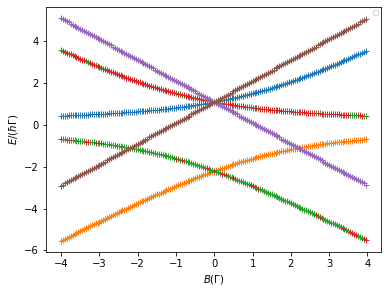

In [114]:
#Since we used gaussian beams, the radial force drops off faster along the x-axis for the MOT45 configuration, because the trapping beam intensity falls off in this direction. 
fig, ax = plt.subplots(1, 1, num='MOT J=1-1', figsize=(6, 2*2.25))

z = np.arange(-4,4,0.05)
Es = np.zeros((z.size, 8))
for ii, z_i in enumerate(z):
    Bq = 0.125*np.array([0.0, magField.Field(np.array([0., 0., z_i]))[2], 0.0])
    Es[ii, :] = np.linalg.eig(ham_fermions.return_full_H({'g->e':np.array([0., 0., 0.])}, Bq))[0]
    
[ax.plot(z, Es[:, 0+jj], '+') for jj in [0,1,2,3,6,7]]
ax.legend(fontsize=6)
ax.set_ylabel('$E/(\hbar \Gamma)$')
ax.set_xlabel('$B (\Gamma)$')



In [115]:
fig.savefig(savepath+'Cd_FermionZeemanShift.png')

In [72]:
#Calculate Zeeman slower and MOT force profile
slowerRE_Fermions = pylcp.rateeq(laserBeams['CdMOTZeemanSlowerSigmaPlus'], permMagnetsPylcp, ham_fermions,include_mag_forces=False)
slowerRE_FermionsLinear = pylcp.rateeq(laserBeams['CdMOTZeemanSlowerLinear'], permMagnetsPylcp, ham_fermions,include_mag_forces=False)
slowerRE = pylcp.rateeq(laserBeams['CdMOTZeemanSlowerSigmaPlus'], permMagnetsPylcp, ham_toy,include_mag_forces=False)
MOT_Fermions = pylcp.rateeq(laserBeams['MOT'], magField, ham_fermions,include_mag_forces=False)
MOT = pylcp.rateeq(laserBeams['MOT'], magField, ham_toy,include_mag_forces=False)

#Do the same for the MOT45 configuration - should see the effect of gaussian beams
dr = 0.1
dv = 0.1
r = beamWidth*np.arange(-35, 20+dr, 2*dr)
v = np.arange(-10, 17+dv, 2*dv)

R, V = np.meshgrid(r, v)


In [73]:
slowerRE_Fermions.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

slowerRE_FermionsLinear.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

slowerRE.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

MOT_Fermions.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

MOT.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);


Completed in 29.94 s.                                               
Completed in 30.09 s.                                               
Completed in 22.14 s.                                               
Completed in 24.75 s.                                               
Completed in 16.81 s.                                               


In [76]:
slowerRE_FermionsOtherCP = pylcp.rateeq(laserBeams['CdMOTZeemanSlower'], permMagnetsPylcp, ham_fermions,include_mag_forces=False)
slowerRE_FermionsOtherCP.generate_force_profile([R, np.zeros(R.shape), np.zeros(R.shape)],
                           [V, np.zeros(V.shape), np.zeros(V.shape)],
                           name='Frad', progress_bar=True);

Completed in 30.33 s.                                               


AttributeError: 'AxesSubplot' object has no attribute 'colorbar'

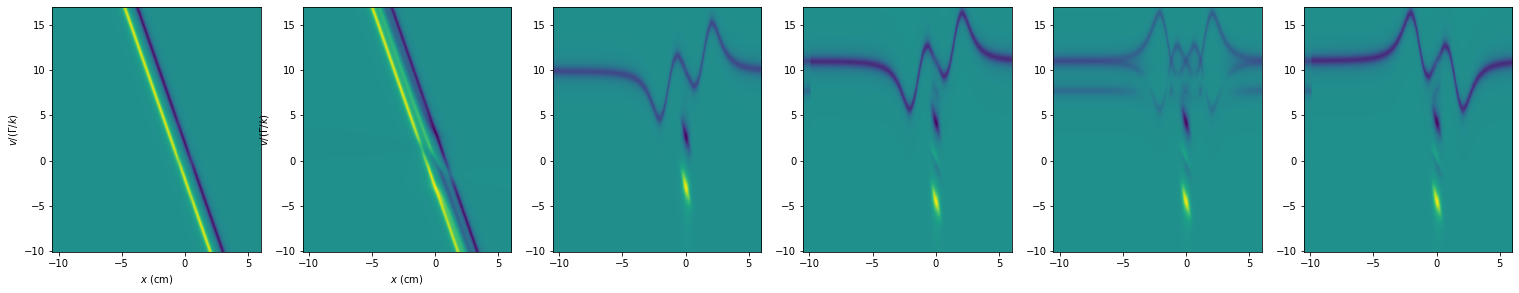

In [77]:
fig, ax = plt.subplots(1, 6, figsize=(26, 2*2.25))

ax[0].imshow(MOT.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')

ax[1].imshow(MOT_Fermions.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')

ax[2].imshow(slowerRE.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')

ax[3].imshow(slowerRE_Fermions.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')

ax[4].imshow(slowerRE_FermionsLinear.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')

ax[5].imshow(slowerRE_FermionsOtherCP.profile['Frad'].F[0], origin='lower',
           extent=(np.amin(r), np.amax(r),
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')

ax[0].set_xlabel('$x$ (cm)')
ax[0].set_ylabel('$v/(\Gamma/k)$')
ax[1].set_xlabel('$x$ (cm)')
ax[1].set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)



cb1 = ax[0].colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')

In [78]:
fig.savefig(savepath+'CdMOT_comparisons.png')